In [1]:
from operator import mul
import urllib2
import numpy as np
import tensorflow as tf


### For home robot

In [ ]:
im_shape = (480, 640, 3)
im_sz = reduce(mul, im_shape)
ROBOT_URL = 'http://localhost:8889/robot/%d/%d/%d/%d/%d/%d/'


def from_buffer(im_str):
    f1 = np.fromstring(im_str, dtype=np.uint8)
    return f1.reshape((480, 640, 3))    
    

def get_images():
    response=urllib2.urlopen('http://localhost:8889/camera')
    left = from_buffer(response.read(im_sz))
    right = from_buffer(response.read(im_sz))
    response.close()
    return left, right


episode_save_location = '/data/robotics/pick_episodes/'
pyrobo_path = "/home/karthik/code/pyrobo/network_models/"

### To be run for office robot


In [2]:
col_sz = (480, 640, 3)
dep_sz = (480, 640)
pnt_sz = (480, 640, 3)
cad_sz = (480, 640, 3)

col_dtype = np.uint8
dep_dtype = np.uint16
cad_dtype = np.uint8
pnt_dtype = np.float32

ROBOT_URL = 'http://robot.local:8888/robot/%d/%d/%d/%d/%d/%d/'

def from_buffer(im_str, sz, dtype_dat):
    f1 = np.fromstring(im_str, dtype=dtype_dat)
    return f1.reshape(sz)    

def get_images():
    response=urllib2.urlopen('http://robot.local:8888/camera')
    col = from_buffer(response.read(reduce(mul, col_sz)), col_sz, col_dtype)
    pnt = from_buffer(response.read(reduce(mul, pnt_sz)*4), pnt_sz, pnt_dtype)
    cad = from_buffer(response.read(reduce(mul, cad_sz)), cad_sz, cad_dtype)
    response.close()
    return col, pnt, cad


episode_save_location = '/data/robotics/auto_episodic_data/'
pyrobo_path = '/Users/kk/code/pyrobo/'

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt


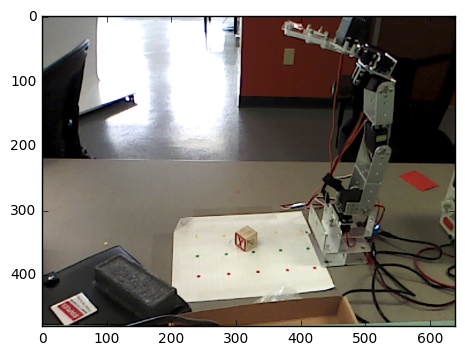

In [4]:
col, pnt, cad = get_images()

plt.imshow(col)

In [ ]:
plt.imshow(right_im)

In [ ]:
import json
def get_ps3_out():
    response=urllib2.urlopen('http://localhost:8888/get')
    js, buttons = json.loads(''.join(response.readlines()))
    pressed_buttons = []
    for (button, state) in js.items():
        if state > 0.5:
            pressed_buttons.append(button)
        if state < -0.5 and button == '1':
            pressed_buttons.append('0')
            
    for (button, state) in buttons.items():
        if state > 0.5:
            pressed_buttons.append(button)
    return pressed_buttons

In [ ]:
get_ps3_out()

In [ ]:
motor_state = {0:1500, 1:1500, 2:1500, 3:1500, 4:1500, 5:1500}

import time
def move_robot():
    url = ROBOT_URL
    ms = [l[1] for l in sorted(motor_state.items(), key=lambda x: x[0])]
    call_url = url%tuple(ms)
    print call_url
    time.sleep(0.1)
    response = urllib2.urlopen(call_url)
    return response.readlines()

def update_state(motor_id, update_direction):
    motor_state[motor_id] = motor_state[motor_id] + 50*update_direction
    move_robot()
    
move_robot()    

In [ ]:
button_motor_map = {"0": [0, -1], "1": [0, +1], 
                    "2": [1, -1], "3": [1, +1],
                    "8": [2, -1], "10":[2, +1],
                    "9": [3, -1], "11":[3, +1],
                    "4": [4, -1], "6": [4, +1],
                    "14":[5, -1], "12":[5, +1]}


In [10]:
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))


# def save_state(writer, left_im, right_im, motor, direction, motor_state):
# l 

def save_record(writer):
    writer.close()

In [ ]:
episode = 0

In [ ]:
pi =  tf.python_io.TFRecordWriter(
"%s_%d.tfrecords"%(episode_save_location, episode))


try:
    while True:
        time.sleep(0.3)
        pressed = get_ps3_out()
        for press in pressed:
            motor, direction = button_motor_map.get(press,[None, None])
            if motor is None:
                continue
            left_im, right_im = get_images()
            
            save_state(pi, left_im, right_im, motor, direction, motor_state)
            update_state(motor, direction)
finally:
    episode+=1
    save_record(pi)
    motor_state = {0:1500, 1:1500, 2:1500, 3:1500, 4:1500, 5:1500}
    move_robot()
    print episode
    

In [ ]:

try:
    while True:
        time.sleep(0.3)
        pressed = get_ps3_out()
        for press in pressed:
            motor, direction = button_motor_map.get(press,[None, None])
            if motor is None:
                continue
#             left_im, right_im = get_images()
            
#             save_state(pi, left_im, right_im, motor, direction, motor_state)
            update_state(motor, direction)
finally:
    episode+=1
    save_record(pi)
    motor_state = {0:1500, 1:1500, 2:1500, 3:1500, 4:1500, 5:1500}
    move_robot()
    print episode


In [5]:
import sys
sys.path.append(pyrobo_path + '/network_models/')
from multicam_net import PurchasePredNet
net = PurchasePredNet()




In [7]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [ ]:
saver = tf.train.Saver()

saver.restore(sess, '/data/robotics/models/pick_episodes/25000_iters')

In [ ]:
import cv2
def rs(arr):
    return cv2.resize(arr, (224, 224)).reshape((1, 224, 224, 3))
left_im, right_im = [rs(x) for x in get_images()]

out_pred = sess.run(tf.nn.softmax(net.layers['out']), { net.left_img:left_im,
                                                    net.right_img: right_im} )

print(out_pred)
choice = np.argmax(out_pred)

motor = choice/2
direction = choice%2*2-1
print(motor, direction)
update_state(motor, direction)
# def extract_motor_direction(choice)

In [27]:
example_out = tf.train.Example(features=tf.train.Features(feature={
                'img_sz': _int32_feature((480, 640, 3))}))


AttributeError: 'module' object has no attribute 'Int32List'

In [22]:
img_sz = example_out.features.feature['img_sz'].int64_list.value

In [23]:
img_sz[0],img_sz[1], img_sz[2]

(480L, 640L, 3L)

In [26]:
def _int32_feature(value):
    return tf.train.Feature(int32_list=tf.train.Int32List(value=value))


In [ ]:
net = 